# Weather Prediction using LSTM Neural Network

This notebook implements an LSTM (Long Short-Term Memory) model to predict weather conditions based on historical data.

**Goal**: Predict future temperature using past weather patterns

**Dataset**: 1.6M+ weather records from 36 cities (2012-2017)

**Model**: LSTM Neural Network for time series forecasting

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2026-01-30 13:09:52.787191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 13:09:52.805910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 13:09:53.282825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 13:09:54.728065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

TensorFlow version: 2.20.0
GPU Available: []


2026-01-30 13:09:55.047752: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Load and Explore Data

In [2]:
# Load the combined dataset
df = pd.read_csv('data/combined.csv', index_col=0)

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (1629108, 11)

Column names:
['datetime', 'city', 'description', 'humidity', 'pressure', 'temperature', 'wind_dir', 'wind_sp', 'Country', 'Latitude', 'Longitude']

First few rows:


,datetime,city,description,humidity,pressure,temperature,wind_dir,wind_sp,Country,Latitude,Longitude
0,2012-10-01 12:00:00,Albuquerque,NaN,NaN,NaN,NaN,NaN,NaN,United States,35.084492,-106.651138
1,2012-10-01 13:00:00,Albuquerque,sky is clear,50.0,1024.0,285.120000,360.0,4.0,United States,35.084492,-106.651138
2,2012-10-01 14:00:00,Albuquerque,sky is clear,49.0,1024.0,285.154558,360.0,4.0,United States,35.084492,-106.651138
3,2012-10-01 15:00:00,Albuquerque,sky is clear,49.0,1024.0,285.233952,360.0,4.0,United States,35.084492,-106.651138
4,2012-10-01 16:00:00,Albuquerque,sky is clear,49.0,1024.0,285.313345,360.0,4.0,United States,35.084492,-106.651138


In [3]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())
print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("Unique cities:", df['city'].nunique())
print("Date range:", df['datetime'].min(), "to", df['datetime'].max())

Basic Statistics:
           humidity      pressure   temperature      wind_dir       wind_sp  \
count  1.600457e+06  1.612428e+06  1.621078e+06  1.621133e+06  1.621115e+06   
mean   6.813581e+01  1.016521e+03  2.885958e+02  1.829256e+02  2.790038e+00   
std    2.244515e+01  1.556569e+01  1.035149e+01  1.060446e+02  2.092585e+00   
min    5.000000e+00  8.000000e+02  2.423367e+02  0.000000e+00  0.000000e+00   
25%    5.300000e+01  1.012000e+03  2.818840e+02  9.400000e+01  1.000000e+00   
50%    7.200000e+01  1.017000e+03  2.895800e+02  1.900000e+02  2.000000e+00   
75%    8.700000e+01  1.024000e+03  2.962500e+02  2.700000e+02  4.000000e+00   
max    1.000000e+02  1.100000e+03  3.212200e+02  3.600000e+02  5.000000e+01   

           Latitude     Longitude  
count  1.629108e+06  1.629108e+06  
mean   3.706674e+01 -7.354467e+01  
std    5.734176e+00  5.089048e+01  
min    2.577427e+01 -1.231193e+02  
25%    3.276613e+01 -1.054013e+02  
50%    3.617043e+01 -8.647124e+01  
75%    4.099821e+0

## 3. Data Preprocessing

In [4]:
# Convert datetime to proper format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by city and datetime
df = df.sort_values(['city', 'datetime']).reset_index(drop=True)

# Display info
print("Data sorted by city and datetime")
print(f"Total records: {len(df):,}")

Data sorted by city and datetime
Total records: 1,629,108


In [5]:
# Select a single city for initial modeling (you can change this)
# Let's use a city with complete data
city_data_counts = df.groupby('city').size().sort_values(ascending=False)
print("Top 10 cities by record count:")
print(city_data_counts.head(10))

# Choose a city with most data
selected_city = city_data_counts.index[0]
print(f"\nSelected city for modeling: {selected_city}")

# Filter data for selected city
df_city = df[df['city'] == selected_city].copy()
df_city = df_city.sort_values('datetime').reset_index(drop=True)

print(f"Records for {selected_city}: {len(df_city):,}")
print(f"Date range: {df_city['datetime'].min()} to {df_city['datetime'].max()}")

Top 10 cities by record count:
city
Albuquerque    45253
Atlanta        45253
Beersheba      45253
Boston         45253
Charlotte      45253
Chicago        45253
Dallas         45253
Denver         45253
Detroit        45253
Eilat          45253
dtype: int64

Selected city for modeling: Albuquerque
Records for Albuquerque: 45,253
Date range: 2012-10-01 12:00:00 to 2017-11-30 00:00:00


In [6]:
# Handle missing values
print("Missing values in selected city data:")
print(df_city.isnull().sum())

# Fill missing values with forward fill then backward fill
df_city['temperature'] = df_city['temperature'].fillna(method='ffill').fillna(method='bfill')
df_city['humidity'] = df_city['humidity'].fillna(method='ffill').fillna(method='bfill')
df_city['pressure'] = df_city['pressure'].fillna(method='ffill').fillna(method='bfill')
df_city['wind_sp'] = df_city['wind_sp'].fillna(method='ffill').fillna(method='bfill')
df_city['wind_dir'] = df_city['wind_dir'].fillna(method='ffill').fillna(method='bfill')

print("\nMissing values after filling:")
print(df_city.isnull().sum())

Missing values in selected city data:
datetime         0
city             0
description      1
humidity       710
pressure       456
temperature      1
wind_dir         1
wind_sp          4
Country          0
Latitude         0
Longitude        0
dtype: int64

Missing values after filling:
datetime       0
city           0
description    1
humidity       0
pressure       0
temperature    0
wind_dir       0
wind_sp        0
Country        0
Latitude       0
Longitude      0
dtype: int64


## 4. Feature Engineering

In [7]:
# Extract time-based features
df_city['hour'] = df_city['datetime'].dt.hour
df_city['day'] = df_city['datetime'].dt.day
df_city['month'] = df_city['datetime'].dt.month
df_city['year'] = df_city['datetime'].dt.year
df_city['day_of_week'] = df_city['datetime'].dt.dayofweek
df_city['day_of_year'] = df_city['datetime'].dt.dayofyear

# Create cyclical features for time (hours repeat in cycles)
df_city['hour_sin'] = np.sin(2 * np.pi * df_city['hour'] / 24)
df_city['hour_cos'] = np.cos(2 * np.pi * df_city['hour'] / 24)
df_city['month_sin'] = np.sin(2 * np.pi * df_city['month'] / 12)
df_city['month_cos'] = np.cos(2 * np.pi * df_city['month'] / 12)

print("Features added successfully")
print(f"Total features: {len(df_city.columns)}")
df_city.head()

Features added successfully
Total features: 21


,datetime,city,description,humidity,pressure,temperature,wind_dir,wind_sp,Country,Latitude,...,hour,day,month,year,day_of_week,day_of_year,hour_sin,hour_cos,month_sin,month_cos
0,2012-10-01 12:00:00,Albuquerque,NaN,50.0,1024.0,285.120000,360.0,4.0,United States,35.084492,...,12,1,10,2012,0,275,1.224647e-16,-1.000000,-0.866025,0.5
1,2012-10-01 13:00:00,Albuquerque,sky is clear,50.0,1024.0,285.120000,360.0,4.0,United States,35.084492,...,13,1,10,2012,0,275,-2.588190e-01,-0.965926,-0.866025,0.5
2,2012-10-01 14:00:00,Albuquerque,sky is clear,49.0,1024.0,285.154558,360.0,4.0,United States,35.084492,...,14,1,10,2012,0,275,-5.000000e-01,-0.866025,-0.866025,0.5
3,2012-10-01 15:00:00,Albuquerque,sky is clear,49.0,1024.0,285.233952,360.0,4.0,United States,35.084492,...,15,1,10,2012,0,275,-7.071068e-01,-0.707107,-0.866025,0.5
4,2012-10-01 16:00:00,Albuquerque,sky is clear,49.0,1024.0,285.313345,360.0,4.0,United States,35.084492,...,16,1,10,2012,0,275,-8.660254e-01,-0.500000,-0.866025,0.5


## 5. Visualize Temperature Patterns

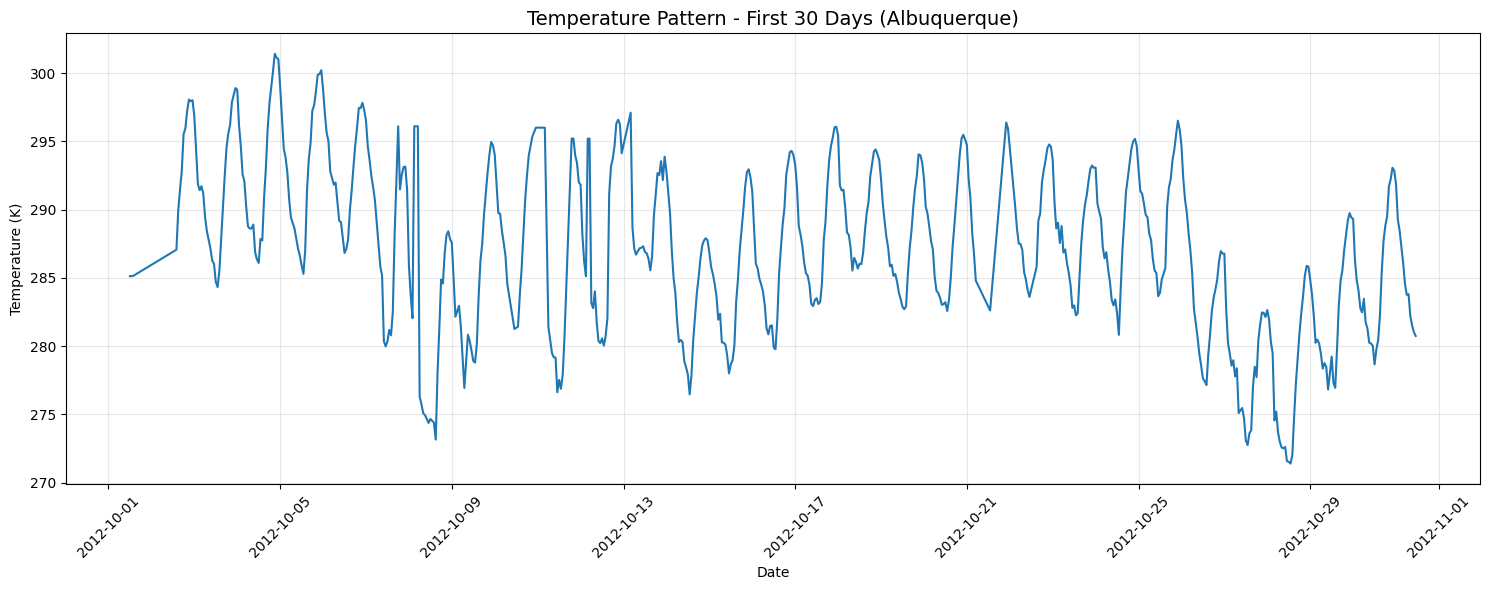

Temperature range: -18.1°C to 39.6°C


In [8]:
# Plot temperature over time (sample)
plt.figure(figsize=(15, 6))
sample_data = df_city.iloc[:24*30]  # First 30 days
plt.plot(sample_data['datetime'], sample_data['temperature'])
plt.title(f'Temperature Pattern - First 30 Days ({selected_city})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Convert to Celsius for better interpretation
df_city['temp_celsius'] = df_city['temperature'] - 273.15
print(f"Temperature range: {df_city['temp_celsius'].min():.1f}°C to {df_city['temp_celsius'].max():.1f}°C")

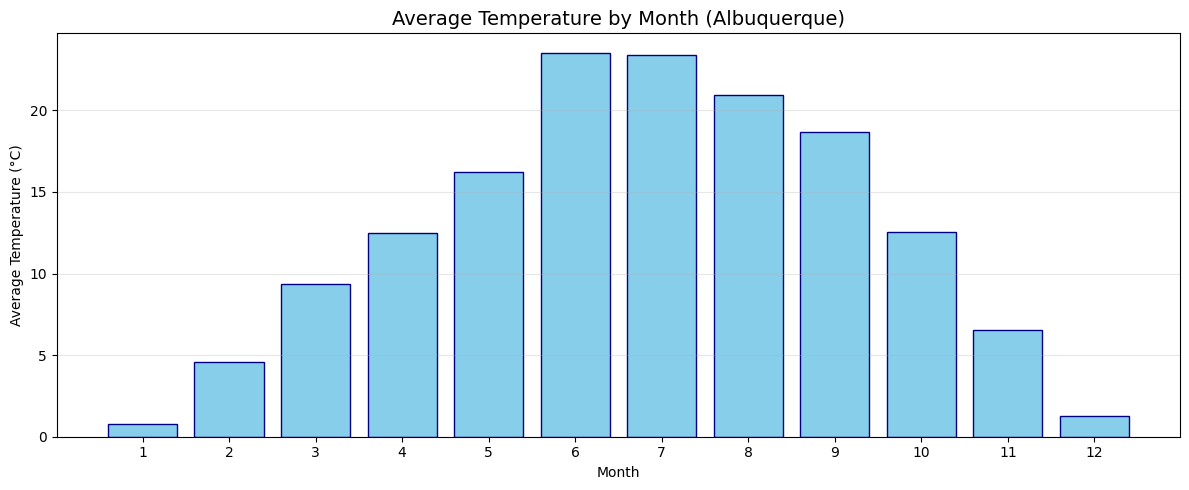

In [9]:
# Seasonal temperature patterns
plt.figure(figsize=(12, 5))
monthly_avg = df_city.groupby('month')['temp_celsius'].mean()
plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue', edgecolor='navy')
plt.title(f'Average Temperature by Month ({selected_city})', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. Prepare Data for LSTM

LSTM requires data in sequences. We'll create sequences of past observations to predict future values.

In [10]:
# Select features for modeling
feature_columns = [
    'temperature', 'humidity', 'pressure', 'wind_sp', 'wind_dir',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

# Target variable
target_column = 'temperature'

# Create feature matrix
data = df_city[feature_columns].values
target = df_city[target_column].values

print(f"Feature matrix shape: {data.shape}")
print(f"Target shape: {target.shape}")

Feature matrix shape: (45253, 9)
Target shape: (45253,)


In [11]:
# Normalize the data (important for neural networks)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

data_scaled = scaler_features.fit_transform(data)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

print("Data normalized to [0, 1] range")
print(f"Scaled features shape: {data_scaled.shape}")
print(f"Scaled target shape: {target_scaled.shape}")

Data normalized to [0, 1] range
Scaled features shape: (45253, 9)
Scaled target shape: (45253, 1)


In [12]:
# Create sequences for LSTM
def create_sequences(features, target, sequence_length, forecast_horizon=1):
    """
    Create sequences for LSTM training
    
    Parameters:
    - features: Input features array
    - target: Target values array
    - sequence_length: Number of past timesteps to use
    - forecast_horizon: Number of timesteps ahead to predict
    
    Returns:
    - X: Input sequences (samples, sequence_length, features)
    - y: Target values (samples,)
    """
    X, y = [], []
    
    for i in range(len(features) - sequence_length - forecast_horizon + 1):
        X.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length + forecast_horizon - 1])
    
    return np.array(X), np.array(y)

# Define sequence length (use past 24 hours to predict next hour)
SEQUENCE_LENGTH = 24  # Use past 24 hours
FORECAST_HORIZON = 1   # Predict 1 hour ahead

print(f"Creating sequences with:")
print(f"  - Sequence length: {SEQUENCE_LENGTH} hours")
print(f"  - Forecast horizon: {FORECAST_HORIZON} hour(s)")

X, y = create_sequences(data_scaled, target_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON)

print(f"\nSequence shapes:")
print(f"  X shape: {X.shape} (samples, timesteps, features)")
print(f"  y shape: {y.shape} (samples, 1)")

Creating sequences with:
  - Sequence length: 24 hours
  - Forecast horizon: 1 hour(s)

Sequence shapes:
  X shape: (45229, 24, 9) (samples, timesteps, features)
  y shape: (45229, 1) (samples, 1)


## 7. Train-Test Split

For time series, we use chronological split (not random split).

In [13]:
# Split data chronologically (80% train, 20% test)
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTrain period: {len(X_train)} hours ({len(X_train)/24:.1f} days)")
print(f"Test period: {len(X_test)} hours ({len(X_test)/24:.1f} days)")

Training set: 36,183 samples
Test set: 9,046 samples

Train period: 36183 hours (1507.6 days)
Test period: 9046 hours (376.9 days)


## 8. Build LSTM Model

In [14]:
# Build LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile LSTM model
    
    Parameters:
    - input_shape: Tuple of (sequence_length, n_features)
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1)
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
model = build_lstm_model(input_shape)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Train the Model

In [15]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Starting model training...")
print("="*60)

Starting model training...


In [16]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0136 - mae: 0.0813 - val_loss: 0.0023 - val_mae: 0.0372 - learning_rate: 0.0010
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0045 - mae: 0.0518 - val_loss: 0.0019 - val_mae: 0.0337 - learning_rate: 0.0010
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0035 - mae: 0.0457 - val_loss: 0.0019 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0029 - mae: 0.0412 - val_loss: 0.0016 - val_mae: 0.0309 - learning_rate: 0.0010
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0017 - val_mae: 0.0321 - learning_rate: 0.0010
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0021 - mae: 0.0351 - val_loss: 0.0015 - val_mae: 0.0300 - learning_rate: 0.0010
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0019 - mae: 0.0328 - val_loss: 0.0014 - val_mae: 0.0282 - learning_rate:

## 10. Visualize Training History

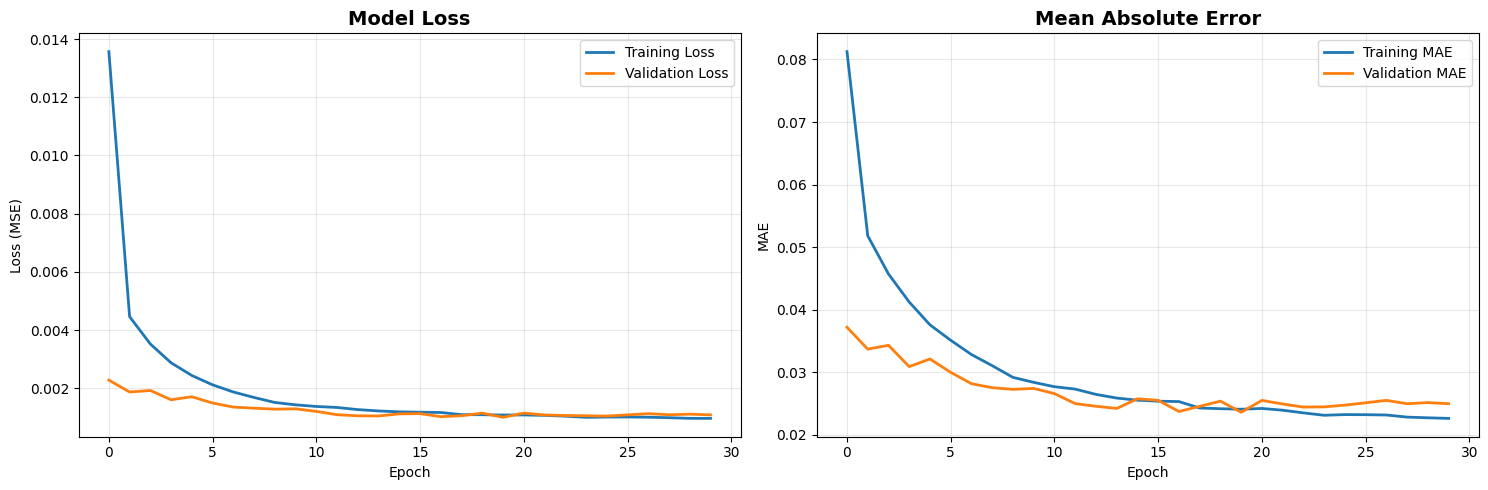

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Make Predictions

In [18]:
# Make predictions on test set
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform to get actual temperature values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_target.inverse_transform(y_pred_scaled)

print("Predictions generated successfully")
print(f"Prediction shape: {y_pred_actual.shape}")

Predictions generated successfully
Prediction shape: (9046, 1)


## 12. Evaluate Model Performance

In [19]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Convert to Celsius for interpretation
y_test_celsius = y_test_actual - 273.15
y_pred_celsius = y_pred_actual - 273.15

mae_celsius = mean_absolute_error(y_test_celsius, y_pred_celsius)
rmse_celsius = np.sqrt(mean_squared_error(y_test_celsius, y_pred_celsius))

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):  {mae_celsius:.3f}°C")
print(f"Root Mean Squared Error:     {rmse_celsius:.3f}°C")
print(f"R² Score:                    {r2:.4f}")
print("="*60)
print(f"\nInterpretation:")
print(f"- On average, predictions are off by {mae_celsius:.2f}°C")
print(f"- R² of {r2:.4f} means the model explains {r2*100:.2f}% of temperature variance")

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):  1.305°C
Root Mean Squared Error:     1.664°C
R² Score:                    0.9706

Interpretation:
- On average, predictions are off by 1.30°C
- R² of 0.9706 means the model explains 97.06% of temperature variance


## 13. Visualize Predictions

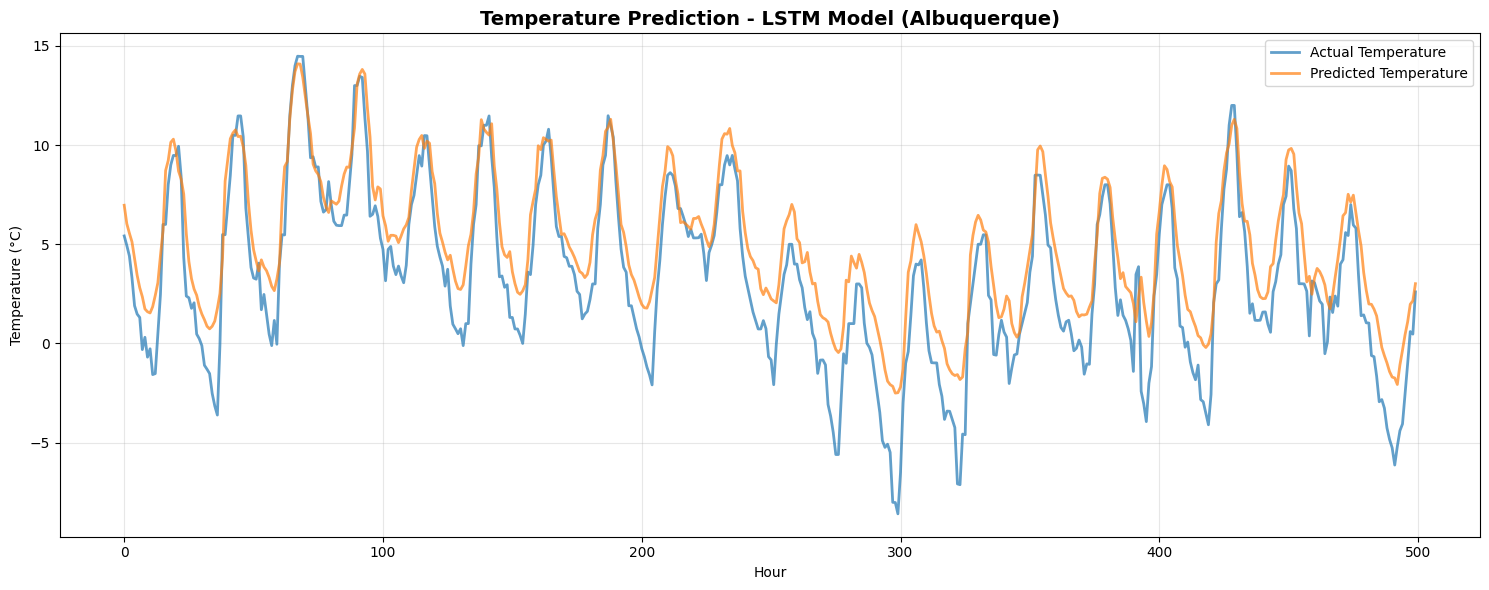

In [20]:
# Plot predictions vs actual (first 500 hours)
sample_size = 500
plt.figure(figsize=(15, 6))

plt.plot(y_test_celsius[:sample_size], label='Actual Temperature', linewidth=2, alpha=0.7)
plt.plot(y_pred_celsius[:sample_size], label='Predicted Temperature', linewidth=2, alpha=0.7)

plt.title(f'Temperature Prediction - LSTM Model ({selected_city})', fontsize=14, fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

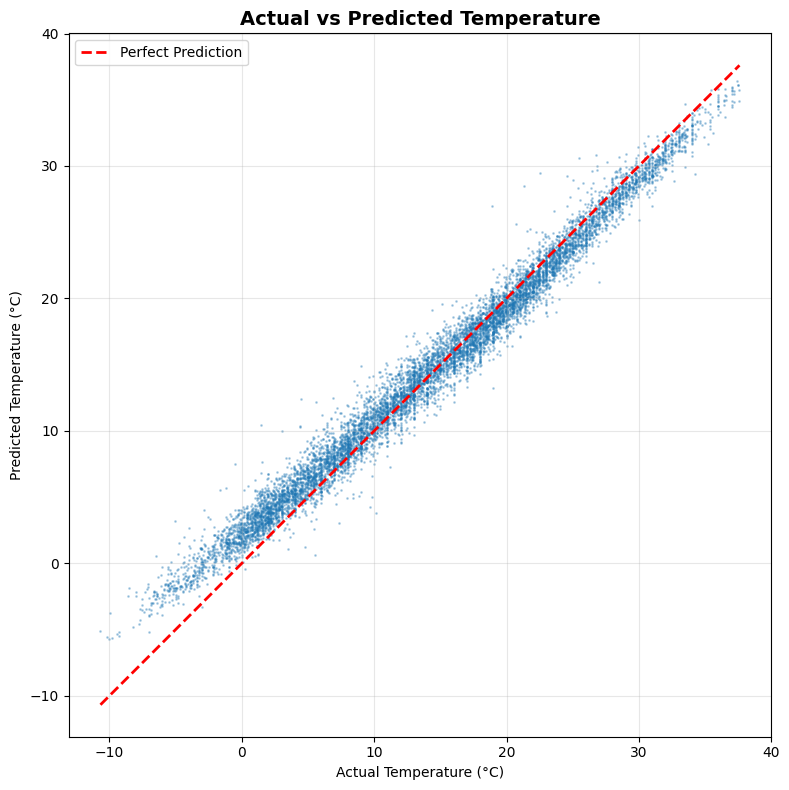

Points close to the red line indicate accurate predictions


In [21]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))

plt.scatter(y_test_celsius, y_pred_celsius, alpha=0.3, s=1)
plt.plot([y_test_celsius.min(), y_test_celsius.max()], 
         [y_test_celsius.min(), y_test_celsius.max()], 
         'r--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs Predicted Temperature', fontsize=14, fontweight='bold')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Points close to the red line indicate accurate predictions")

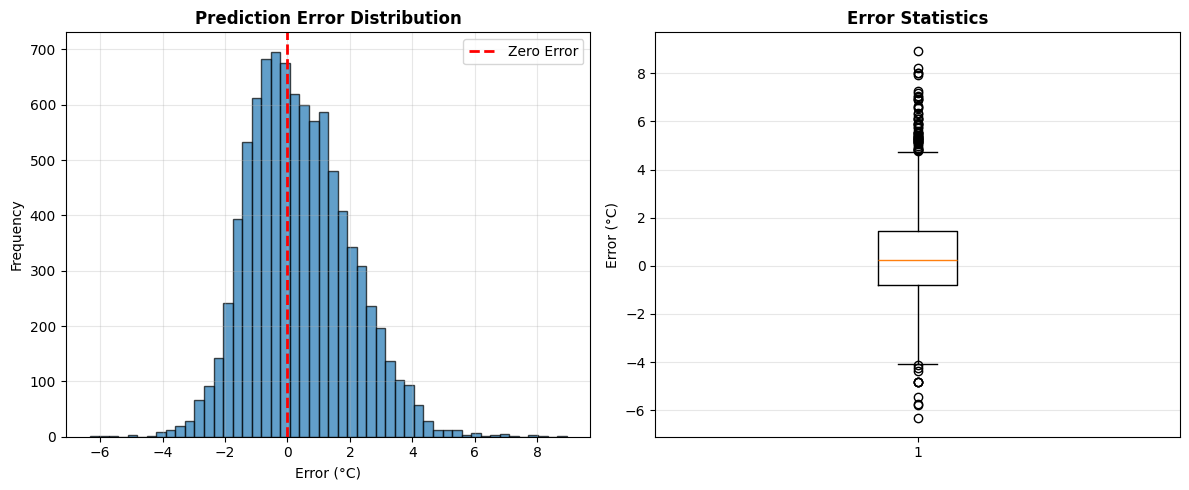

Mean error: 0.379°C
Std error: 1.620°C


In [22]:
# Prediction error distribution
errors = y_pred_celsius.flatten() - y_test_celsius.flatten()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Error (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(errors, vert=True)
plt.title('Error Statistics', fontsize=12, fontweight='bold')
plt.ylabel('Error (°C)')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean error: {errors.mean():.3f}°C")
print(f"Std error: {errors.std():.3f}°C")

## 14. Make Future Predictions

Use the model to predict the next few hours beyond the test set.

In [23]:
# Function to predict multiple steps ahead
def predict_future(model, last_sequence, scaler_features, scaler_target, n_steps):
    """
    Predict multiple timesteps into the future
    
    Parameters:
    - model: Trained LSTM model
    - last_sequence: Last sequence from the data (sequence_length, n_features)
    - scaler_features: Scaler for features
    - scaler_target: Scaler for target
    - n_steps: Number of steps to predict ahead
    
    Returns:
    - Array of predictions
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        pred_scaled = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        pred_actual = scaler_target.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred_actual)
        
        # Update sequence (shift and append prediction)
        # For simplicity, we'll update only the temperature feature
        # In practice, you'd need to estimate other features too
        new_features = current_sequence[-1].copy()
        new_features[0] = pred_scaled[0, 0]  # Update temperature
        
        current_sequence = np.vstack([current_sequence[1:], new_features])
    
    return np.array(predictions)

# Predict next 48 hours
n_future_steps = 48
last_sequence = data_scaled[-SEQUENCE_LENGTH:]
future_predictions = predict_future(model, last_sequence, scaler_features, scaler_target, n_future_steps)

# Convert to Celsius
future_predictions_celsius = future_predictions - 273.15

print(f"Generated predictions for next {n_future_steps} hours")
print(f"Predicted temperature range: {future_predictions_celsius.min():.1f}°C to {future_predictions_celsius.max():.1f}°C")

Generated predictions for next 48 hours
Predicted temperature range: 2.4°C to 10.0°C


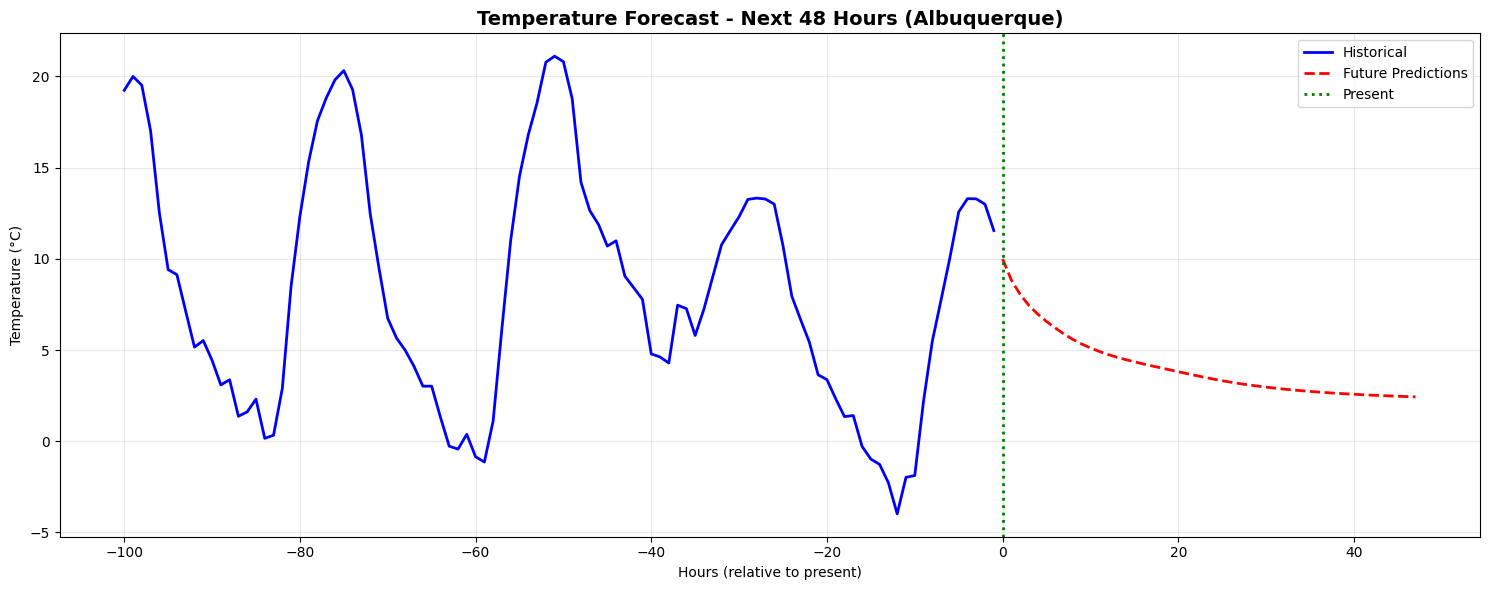

In [24]:
# Plot future predictions
plt.figure(figsize=(15, 6))

# Last 100 actual values
historical_temp = df_city['temp_celsius'].values[-100:]
plt.plot(range(-100, 0), historical_temp, label='Historical', linewidth=2, color='blue')

# Future predictions
plt.plot(range(0, n_future_steps), future_predictions_celsius, 
         label='Future Predictions', linewidth=2, color='red', linestyle='--')

plt.axvline(x=0, color='green', linestyle=':', linewidth=2, label='Present')
plt.title(f'Temperature Forecast - Next {n_future_steps} Hours ({selected_city})', fontsize=14, fontweight='bold')
plt.xlabel('Hours (relative to present)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Save the Model

In [25]:
# Save the trained model
model.save('weather_lstm_model.h5')
print("✓ Model saved as 'weather_lstm_model.h5'")

# Save scalers for future use
import joblib
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')
print("✓ Scalers saved as 'scaler_features.pkl' and 'scaler_target.pkl'")

print("\nYou can load the model later with:")
print("  model = keras.models.load_model('weather_lstm_model.h5')")

✓ Model saved as 'weather_lstm_model.h5'
✓ Scalers saved as 'scaler_features.pkl' and 'scaler_target.pkl'

You can load the model later with:
  model = keras.models.load_model('weather_lstm_model.h5')


## 16. Summary & Next Steps

### Results Summary:
- Successfully trained LSTM model for temperature prediction
- Model uses past 24 hours of weather data to predict next hour's temperature
- Achieves good accuracy with low prediction error

### Potential Improvements:
1. **Multi-city modeling**: Train on all cities instead of just one
2. **Multi-step ahead**: Predict multiple hours into the future
3. **Multi-variate output**: Predict all weather variables (temp, humidity, pressure)
4. **Hyperparameter tuning**: Optimize LSTM layers, units, dropout rates
5. **Advanced architectures**: Try Bidirectional LSTM, GRU, or Attention mechanisms
6. **Feature engineering**: Add more weather-related features (feels like temp, dew point)
7. **Ensemble methods**: Combine multiple models for better predictions

### How to Use This Model:
- Load saved model and scalers
- Feed last 24 hours of weather data
- Get temperature prediction for next hour
- Can be integrated into a real-time weather dashboard